In [ ]:
import numpy as np
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess

from data.data import get_switzerland_temperature, get_victoria_electricity_demand, get_periodic_process
from utils import get_figure, time_plot, arma_theoretical_spectral_density, plot_fft, moving_average_smoothing

### ... Exercises below

## Spectral leakage

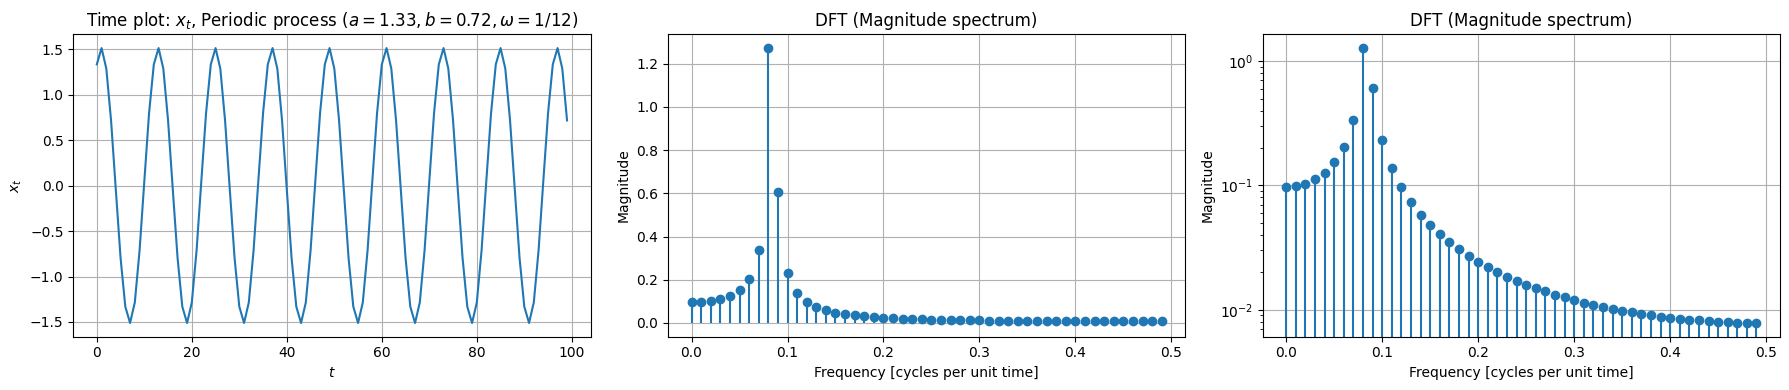

In [ ]:
n = 100
x_t, x_name = get_periodic_process(seed=10, npoints=n, sd=1, period=12)

fig, (ax1, ax2, ax3) = get_figure(ncols=3, figsize=(18, 4))
time_plot(
    np.arange(len(x_t)),
    x_t,
    title=f"$x_t$, {x_name}",
    prefix_title=True,
    ax=ax1,
)
plot_fft(
    ax2,
    x_t,
    periodogram=False,
)
plot_fft(
    ax3,
    x_t,
    periodogram=False,
    log_scale=True,
)
fig.tight_layout()

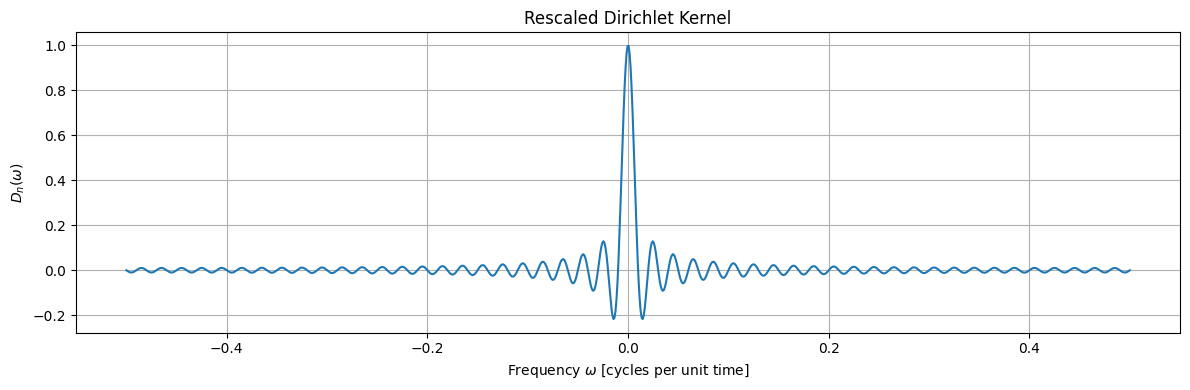

In [ ]:
omega = np.linspace(-.5, .5, 1000)
dirichlet_kernel = np.sin(np.pi * omega * n) / (n * np.sin(np.pi * omega))

time_plot(
    omega,
    dirichlet_kernel,
    title="Rescaled Dirichlet Kernel",
    xlabel=r"Frequency $\omega$ [cycles per unit time]",
    ylabel=r"$D_n(\omega)$",
)

## Periodogram bias

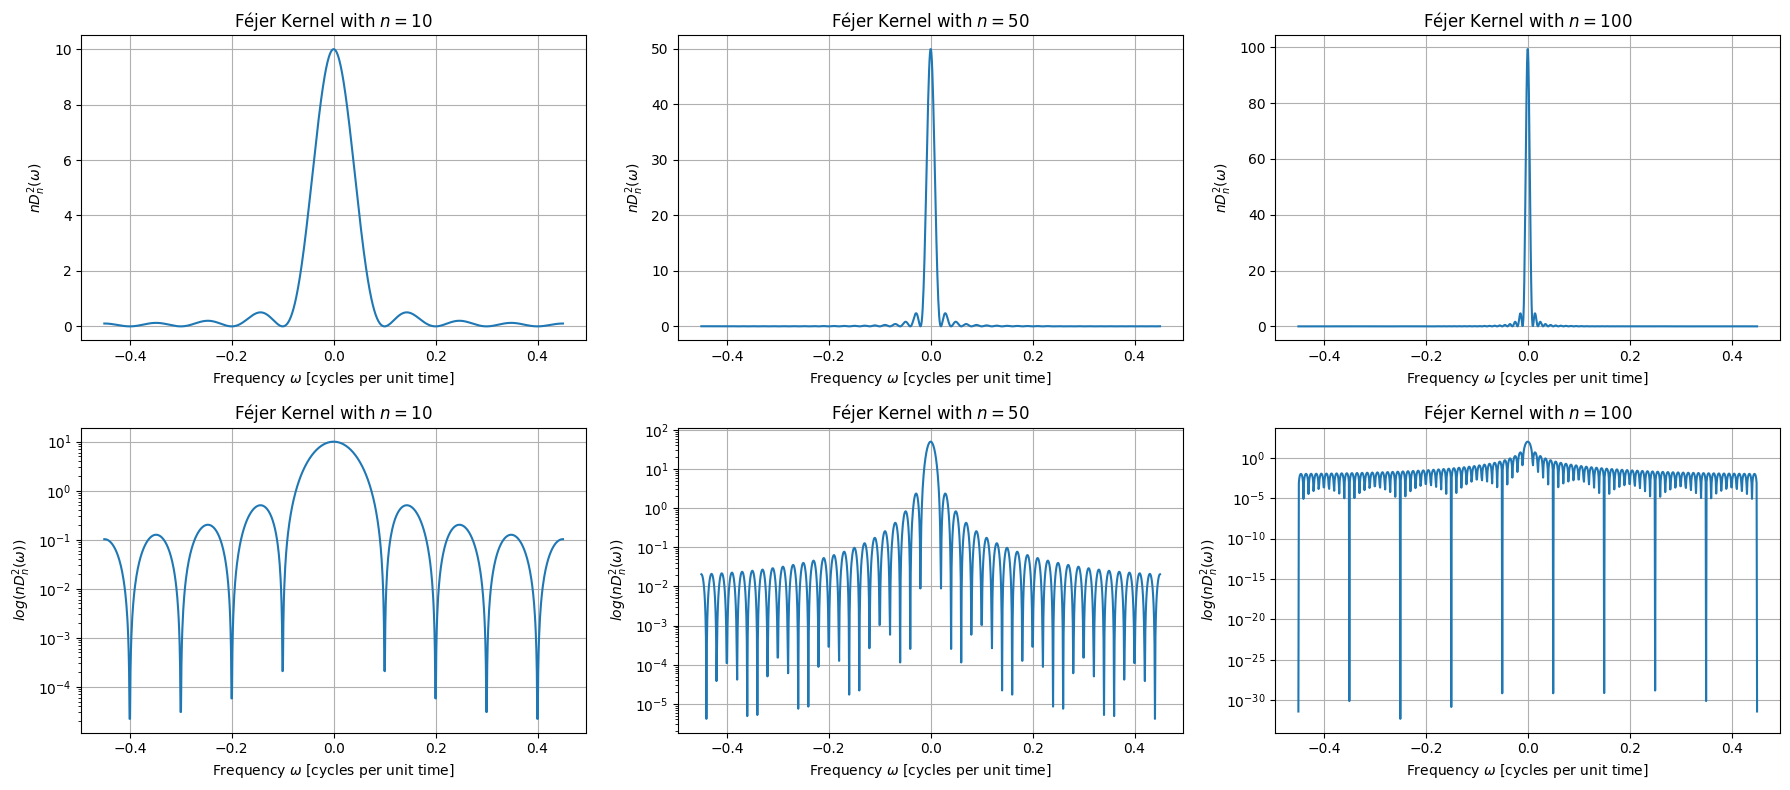

In [ ]:
frequencies = np.linspace(-.45, .45, 1000)
fig, axs = get_figure(nrows=2, ncols=3, figsize=(18, 8))
for i, n in enumerate([10, 50, 100]):
    fejer_kernel = np.sin(np.pi * frequencies * n)**2 / (n * np.sin(np.pi * frequencies)**2)
    time_plot(
        frequencies,
        fejer_kernel,
        title=f"Féjer Kernel with $n={n}$",
        xlabel=r"Frequency $\omega$ [cycles per unit time]",
        ylabel=r"$nD_n^2(\omega)$",
        ax=axs[i],
    )
    time_plot(
        frequencies,
        fejer_kernel,
        title=f"Féjer Kernel with $n={n}$",
        xlabel=r"Frequency $\omega$ [cycles per unit time]",
        ylabel=r"$log(nD_n^2(\omega))$",
        ax=axs[i+3],
    )
    axs[i+3].set_yscale('log')
fig.tight_layout()

## Tapering

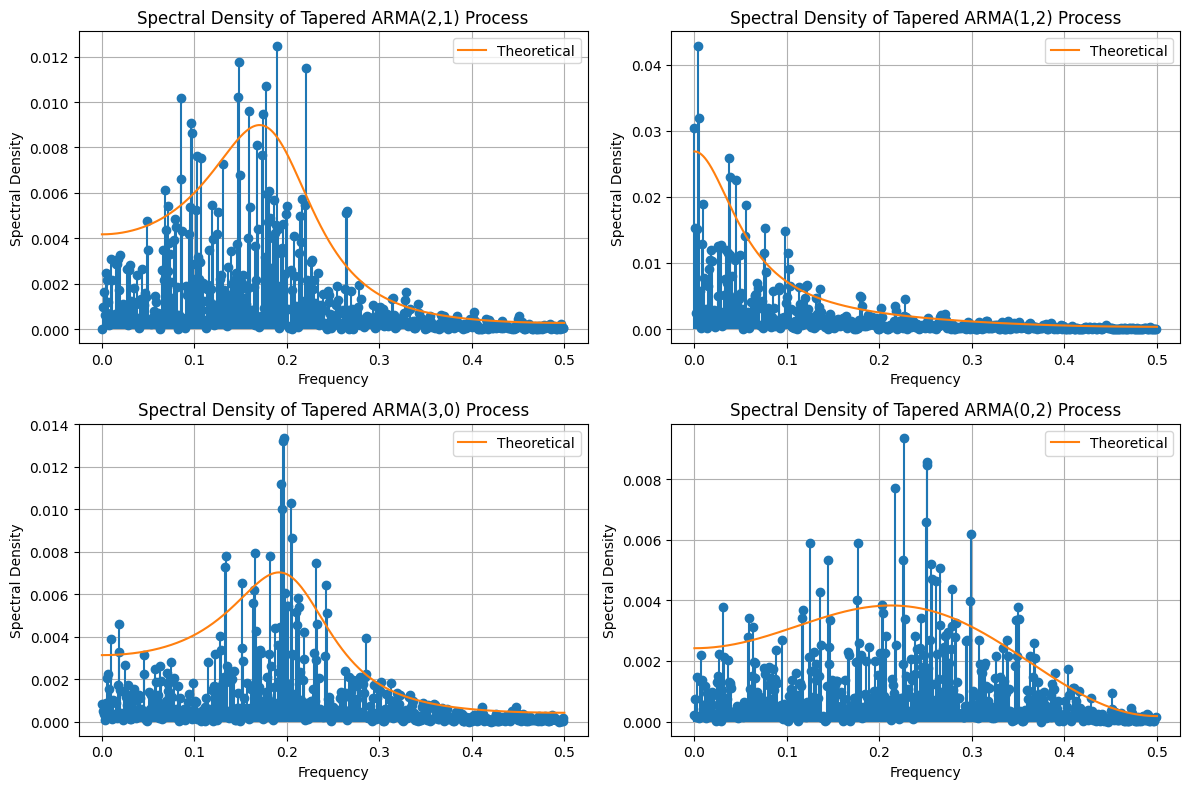

In [ ]:
np.random.seed(42)
n = 1000
sigma = 1
arma_configs = [
    {"phi": [0.5, -0.4], "theta": [0.3], "label": "ARMA(2,1)"},
    {"phi": [0.7], "theta": [0.2, -0.1], "label": "ARMA(1,2)"},
    {"phi": [0.6, -0.5, 0.1], "theta": [], "label": "ARMA(3,0)"},
    {"phi": [], "theta": [0.4, -0.3], "label": "ARMA(0,2)"},
]
frequencies = np.linspace(0, 0.5, n)
nrows= np.ceil(len(arma_configs)/2)
fig, axs = get_figure(nrows=len(arma_configs)//2, ncols=2, figsize=(12, 8))
for ax, config in zip(axs, arma_configs):
    phi = config["phi"]
    theta = config["theta"]
    label = config["label"]
    
    model = ArmaProcess(
        ar=np.r_[1, -np.array(phi)],
        ma=np.r_[1, np.array(theta)],
    )
    arma_series = model.generate_sample(nsample=n)
    spectral_density = arma_theoretical_spectral_density(frequencies, sigma, phi, theta)
    # Multiply by two for the negative frequencies, divide by n to relate to the periodogram since P(w) = f(w)/n
    spectral_density = 2*spectral_density/n
    
    tapered_series = signal.windows.hann(n) * arma_series
    
    plot_fft(
        ax,
        tapered_series,
        periodogram=True,
    )
    time_plot(
        frequencies,
        spectral_density,
        title=f"Spectral Density of Tapered {label} Process",
        xlabel="Frequency",
        ylabel="Spectral Density",
        label="Theoretical",
        ax=ax,
    )
fig.tight_layout()

In [ ]:
def compare_with_taper(data, title, ylabel, smoothing=False, **kwargs):
    data = data - data.mean()
    tapered_data = data * signal.windows.hann(len(data))

    fig, axs = get_figure(nrows=2, ncols=3, figsize=(18, 8))
    time_plot(
        x=data.index,
        y=data,
        title=title,
        xlabel='Time',
        ylabel=ylabel,
        ax=axs[0],
    )
    plot_fft(
        axs[1],
        data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        show_estimated_density=smoothing,
        **kwargs
    )
    plot_fft(
        axs[2],
        data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        log_scale=True,
        show_estimated_density=smoothing,
        **kwargs
    )
    time_plot(
        x=tapered_data.index,
        y=tapered_data,
        title=f"Tapered {title}",
        xlabel='Time',
        ylabel=ylabel,
        ax=axs[3],
    )
    plot_fft(
        axs[4],
        tapered_data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        show_estimated_density=smoothing,
        **kwargs
    )
    plot_fft(
        axs[5],
        tapered_data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        log_scale=True,
        show_estimated_density=smoothing,
        **kwargs
    )
    if smoothing:
        axs[1].legend()
    fig.tight_layout()

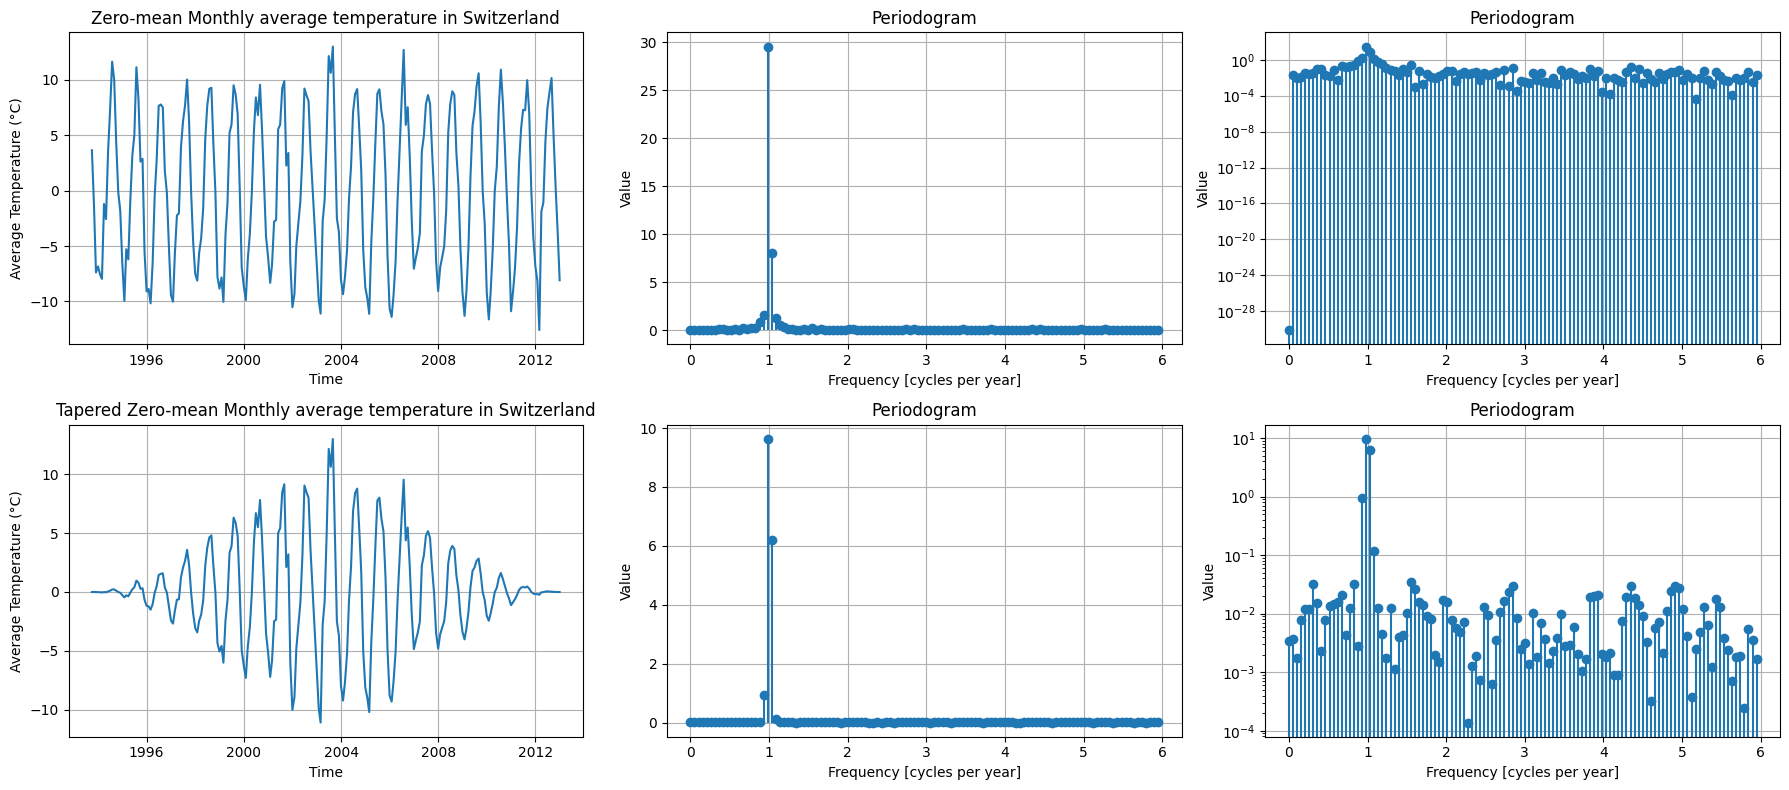

In [ ]:
data = get_switzerland_temperature().set_index('dt').asfreq('ME')['AverageTemperature']
compare_with_taper(data, 'Zero-mean Monthly average temperature in Switzerland', 'Average Temperature (°C)')

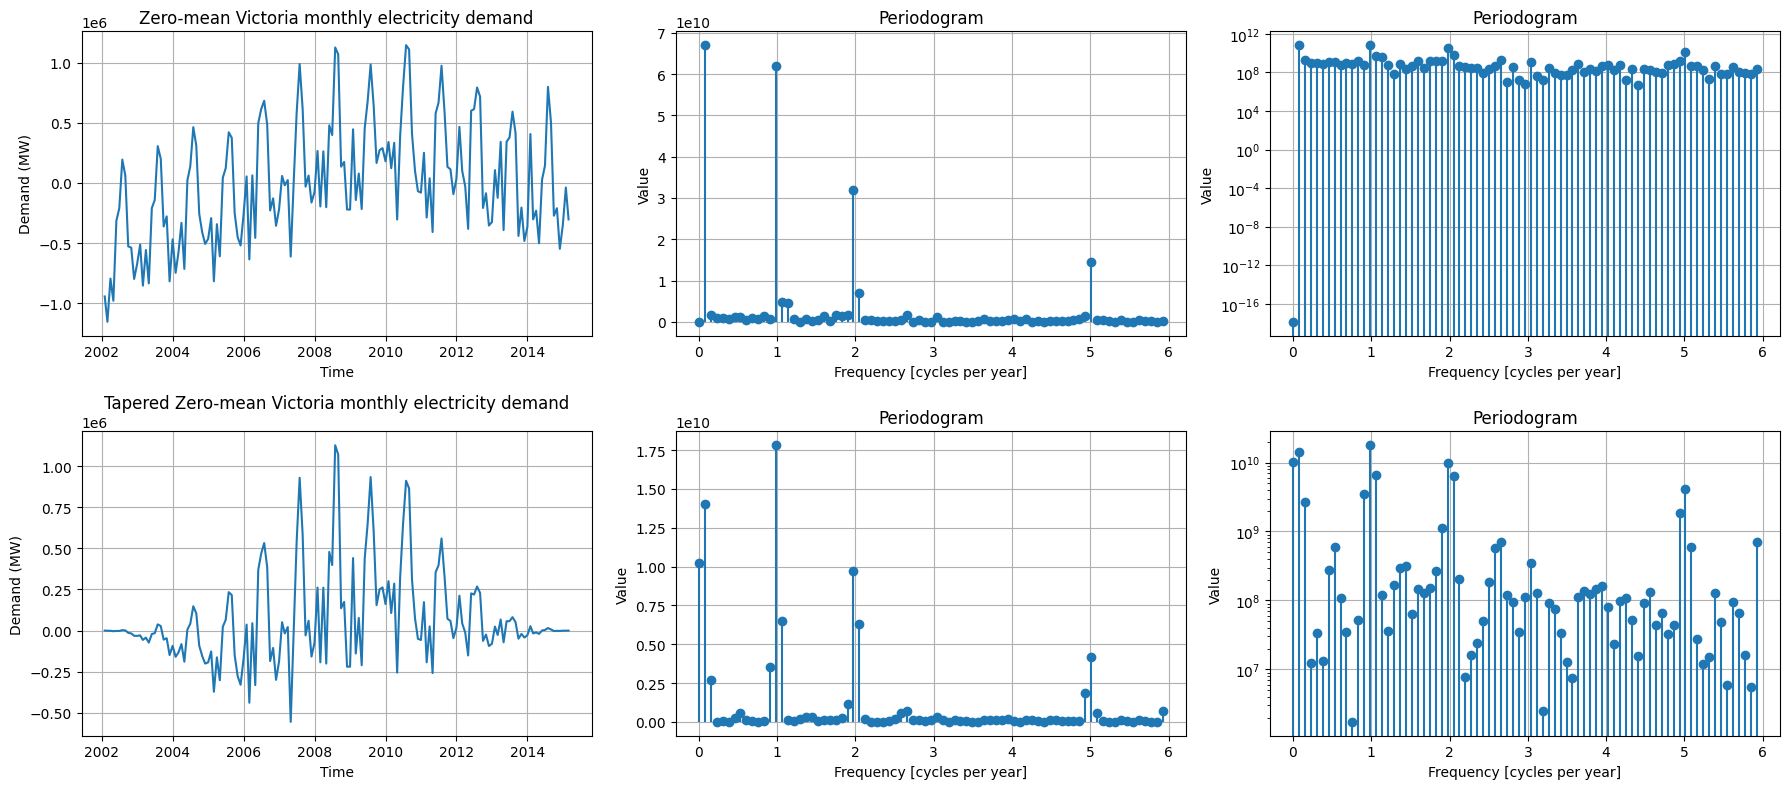

In [ ]:
data = get_victoria_electricity_demand()["OperationalLessIndustrial"]
compare_with_taper(data, 'Zero-mean Victoria monthly electricity demand', 'Demand (MW)')

## Smoothed periodogram

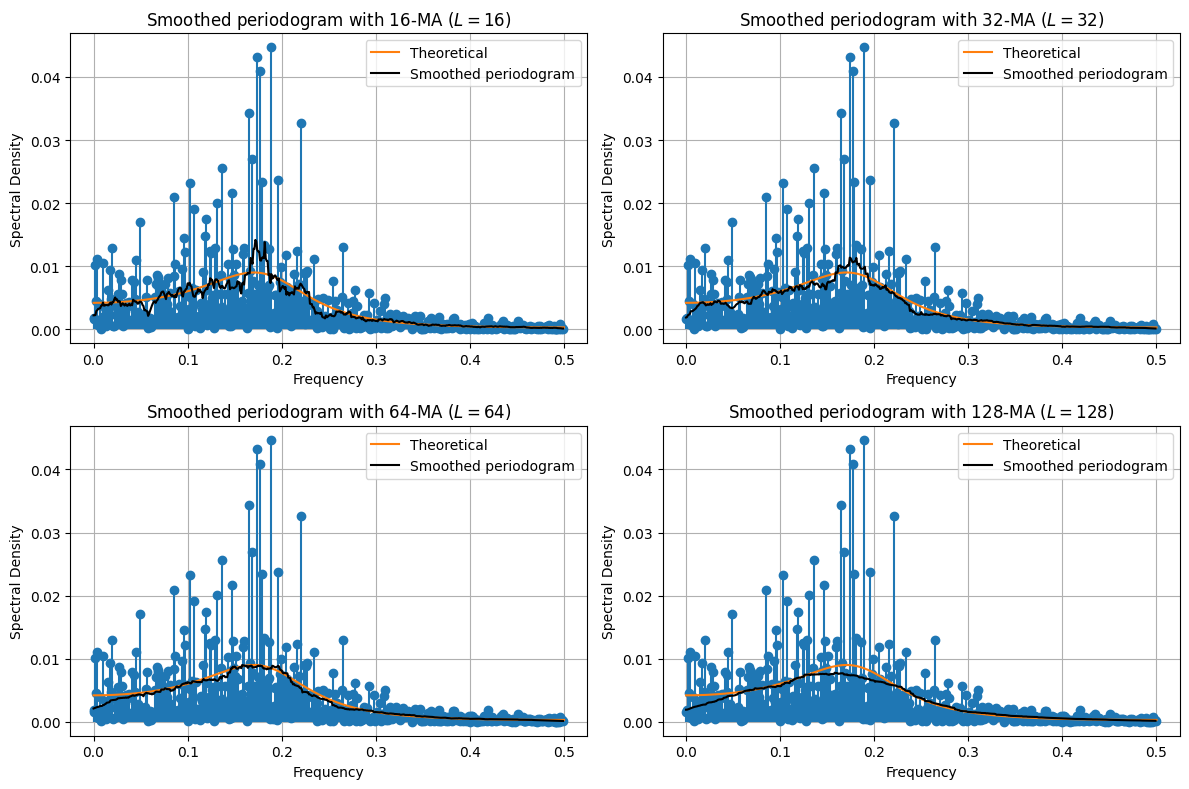

In [ ]:
np.random.seed(42)
n=1000
sigma = 1
frequencies = np.linspace(0, 0.5, n)
config = {"phi": [0.5, -0.4], "theta": [0.3], "label": "ARMA(2,1)"}
phi = config["phi"]
theta = config["theta"]
label = config["label"]

model = ArmaProcess(
    ar=np.r_[1, -np.array(phi)],
    ma=np.r_[1, np.array(theta)],
)
arma_series = model.generate_sample(nsample=n)
spectral_density = arma_theoretical_spectral_density(frequencies, sigma, phi, theta)
# Multiply by two for the negative frequencies, divide by n to relate to the periodogram since P(w) = f(w)/n
spectral_density = 2*spectral_density/n
fig, axs = get_figure(nrows=2, ncols=2, figsize=(12, 8))
for ax, wsize in zip(axs, [16, 32, 64, 128]):
    xf, _, periodogram = plot_fft(
        ax,
        arma_series,
        periodogram=True,
        return_fft=True,
    )
    time_plot(
        frequencies,
        spectral_density,
        title=f"Smoothed periodogram with {wsize}-MA ($L={wsize}$)",
        xlabel="Frequency",
        ylabel="Spectral Density",
        label="Theoretical",
        ax=ax,
    )
    
    _, _, smoothed_periodogram = moving_average_smoothing(periodogram, window_size=wsize, mode='same')
    ax.plot(xf, smoothed_periodogram, label="Smoothed periodogram", color='black')
    ax.legend()
fig.tight_layout()

In [ ]:
def compare_with_smoothing(data, title, ylabel, smoothing_window_percent):
    data = data - data.mean()
    data = data * signal.windows.hann(len(data))

    fig, axs = get_figure(nrows=2, ncols=3, figsize=(18, 8))
    time_plot(
        x=data.index,
        y=data,
        title=title,
        xlabel='Time',
        ylabel=ylabel,
        ax=axs[0],
    )
    plot_fft(
        axs[1],
        data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        show_estimated_density=True,
        smoothing_iteration=1,
        smoothing_window_percent=smoothing_window_percent,
    )
    plot_fft(
        axs[2],
        data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        log_scale=True,
        show_estimated_density=True,
        smoothing_iteration=1,
        smoothing_window_percent=smoothing_window_percent,
    )
    time_plot(
        x=data.index,
        y=data,
        title=f"Tapered {title}",
        xlabel='Time',
        ylabel=ylabel,
        ax=axs[3],
    )
    plot_fft(
        axs[4],
        data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        show_estimated_density=True,
        smoothing_iteration=2,
        smoothing_window_percent=smoothing_window_percent,
    )
    plot_fft(
        axs[5],
        data,
        sample_spacing=1 / 12,
        sample_spacing_name="year",
        periodogram=True,
        log_scale=True,
        show_estimated_density=True,
        smoothing_iteration=2,
        smoothing_window_percent=smoothing_window_percent,
    )
    axs[1].legend()
    axs[4].legend()
    fig.tight_layout()

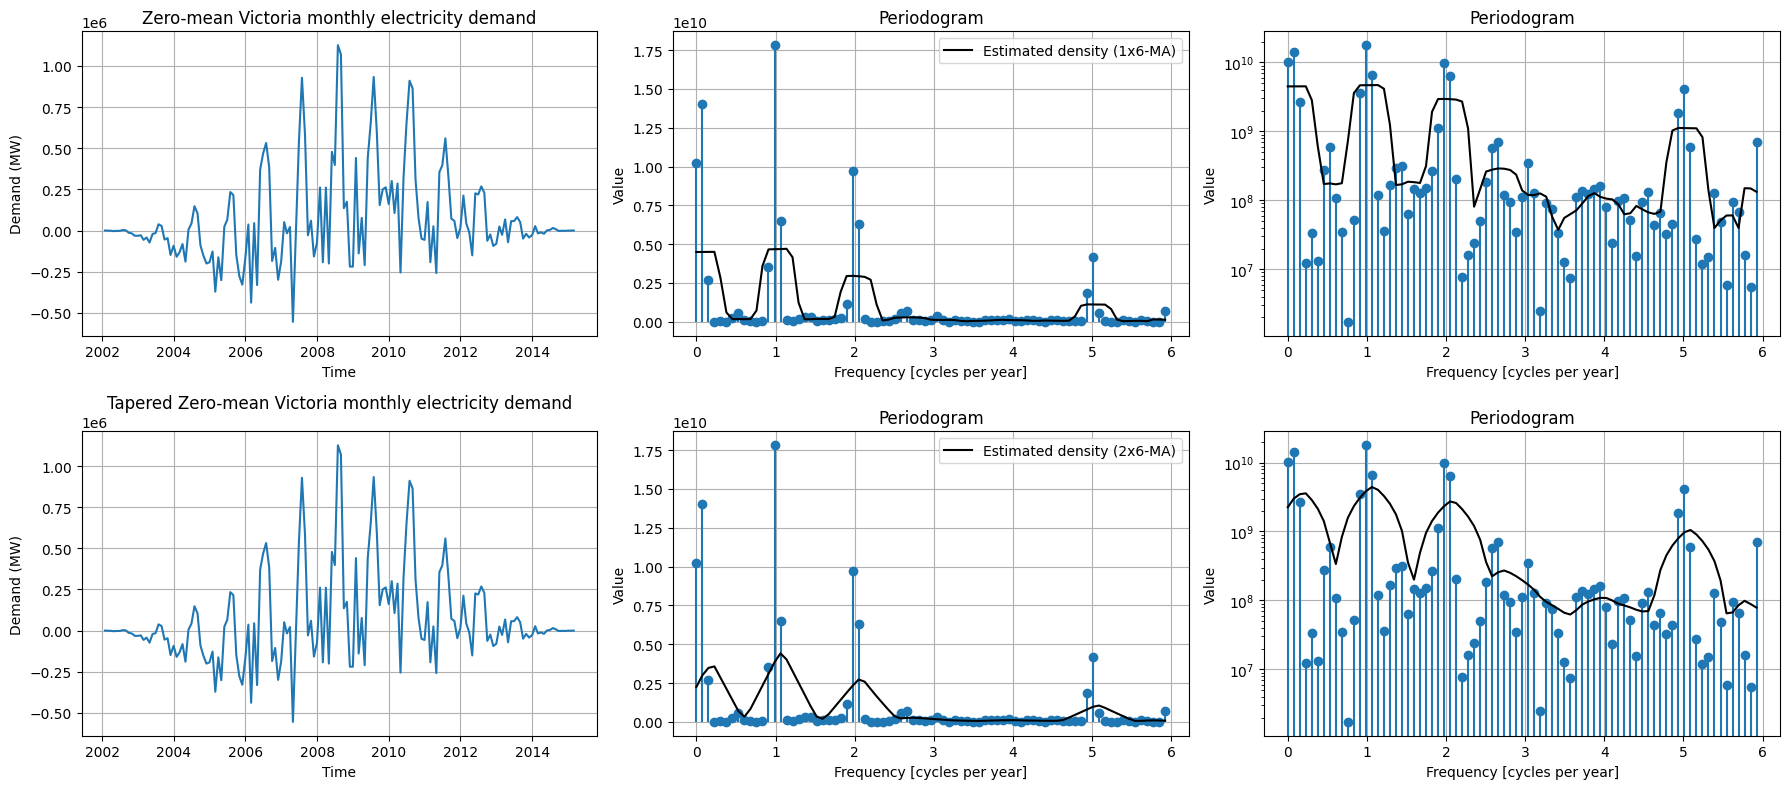

In [ ]:
data = get_victoria_electricity_demand()["OperationalLessIndustrial"]
compare_with_smoothing(data, 'Zero-mean Victoria monthly electricity demand', 'Demand (MW)', 0.04)

## Linear filters

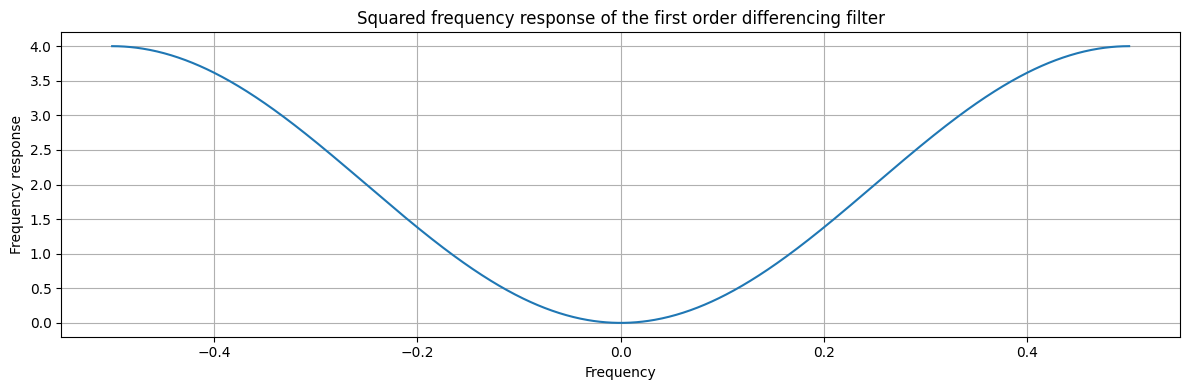

In [ ]:
frequencies = np.linspace(-0.5, 0.5, 1000)
A_squared = 2*(1-np.cos(2*np.pi*frequencies))
time_plot(
    frequencies,
    A_squared,
    title="Squared frequency response of the first order differencing filter",
    xlabel="Frequency",
    ylabel="Frequency response",
)

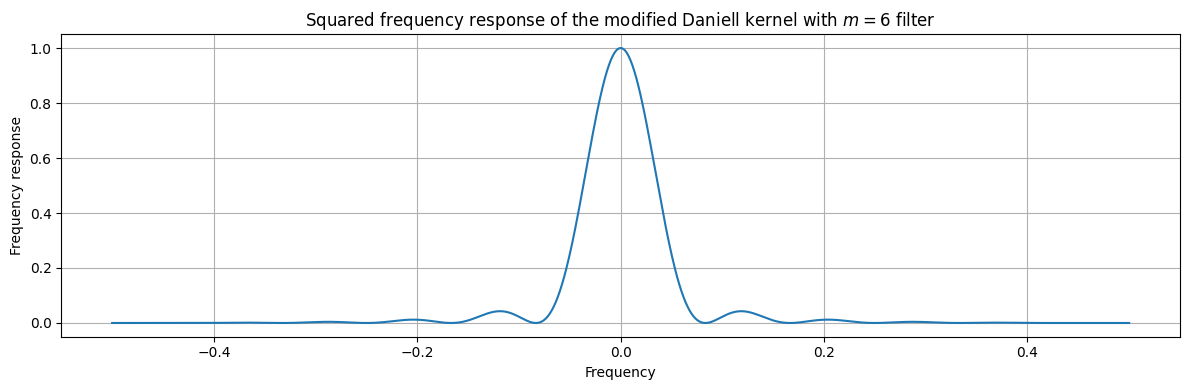

In [ ]:
frequencies = np.linspace(-0.5, 0.5, 1000)
A = (1+np.cos(12*np.pi*frequencies)+2*sum(np.cos(2*np.pi*frequencies*k) for k in range(1,6)))/12
A_squared = A**2
time_plot(
    frequencies,
    A_squared,
    title="Squared frequency response of the modified Daniell kernel with $m=6$ filter",
    xlabel="Frequency",
    ylabel="Frequency response",
)

### Exercise 
Compare different tapering windows, their properties and use cases.<br>
• How energy spreads around peaks.<br>
• How frequencies are attenuated.<br>

Compare different linear filters, their properties and use cases.<br>

Evaluate the effect of tapering, smoothing, filtering on your real-world data.<br>
• Review the spectrum in log scale.<br>
• Apply different tapering windows.<br>
• Determine appropriate smoothing strength.<br>
• Review the effect of different filters.<br>

### Comparing tapering windows

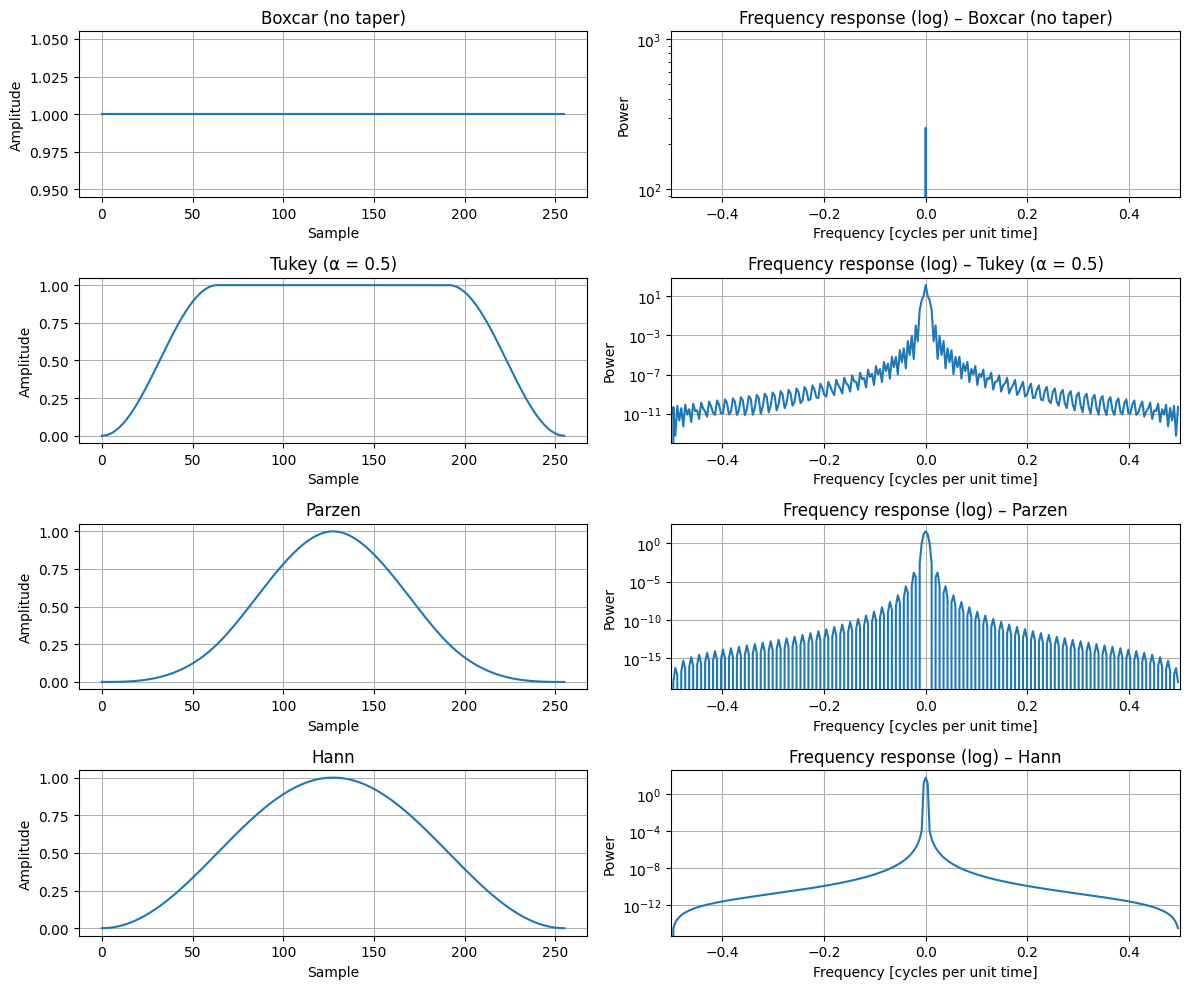

In [ ]:
import matplotlib.pyplot as plt

n = 256
t = np.arange(n)

windows = [
    ("Boxcar (no taper)", np.ones(n)),
    ("Tukey (α = 0.5)", signal.windows.tukey(n, alpha=0.5)),
    ("Parzen", signal.windows.parzen(n)),
    ("Hann", signal.windows.hann(n)),
]

fig, axs = get_figure(nrows=len(windows), ncols=2, figsize=(12, 10))

for i, (name, w) in enumerate(windows):
    # Time-domain window
    time_plot(
        t,
        w,
        title=name,
        xlabel="Sample",
        ylabel="Amplitude",
        ax=axs[2*i],
    )
    
    
    W = np.fft.fftshift(np.fft.fft(w))
    freqs = np.fft.fftshift(np.fft.fftfreq(n, d=1))
    power = np.abs(W)**2 / n

    axs[2*i + 1].plot(freqs, power)
    axs[2*i + 1].set_yscale("log")
    axs[2*i + 1].set_xlim(-0.5, 0.5)
    axs[2*i + 1].set_title(f"Frequency response (log) – {name}")
    axs[2*i + 1].set_xlabel("Frequency [cycles per unit time]")
    axs[2*i + 1].set_ylabel("Power")

fig.tight_layout()


### Comparing linear filter: high-pass filter and low-pass filter

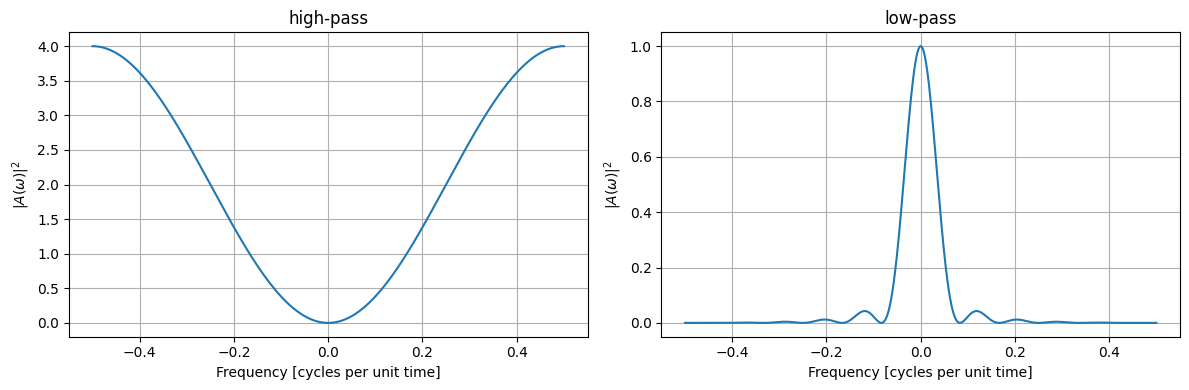

In [ ]:

frequencies = np.linspace(-0.5, 0.5, 1000)

# high-pass
A2_diff = 2 * (1 - np.cos(2 * np.pi * frequencies))  # |A(ω)|^2 from slide 24

fig, axs = get_figure(nrows=1, ncols=2, figsize=(12, 4))

time_plot(
    frequencies,
    A2_diff,
    title="high-pass",
    xlabel="Frequency [cycles per unit time]",
    ylabel=r"$|A(\omega)|^2$",
    ax=axs[0],
)

# low-pass
A = (1 + np.cos(12 * np.pi * frequencies) +
     2 * sum(np.cos(2 * np.pi * frequencies * k) for k in range(1, 6))) / 12
A2_daniell = A**2

time_plot(
    frequencies,
    A2_daniell,
    title="low-pass",
    xlabel="Frequency [cycles per unit time]",
    ylabel=r"$|A(\omega)|^2$",
    ax=axs[1],
)

fig.tight_layout()


### Sea surface temperarture - effect of different tapering window

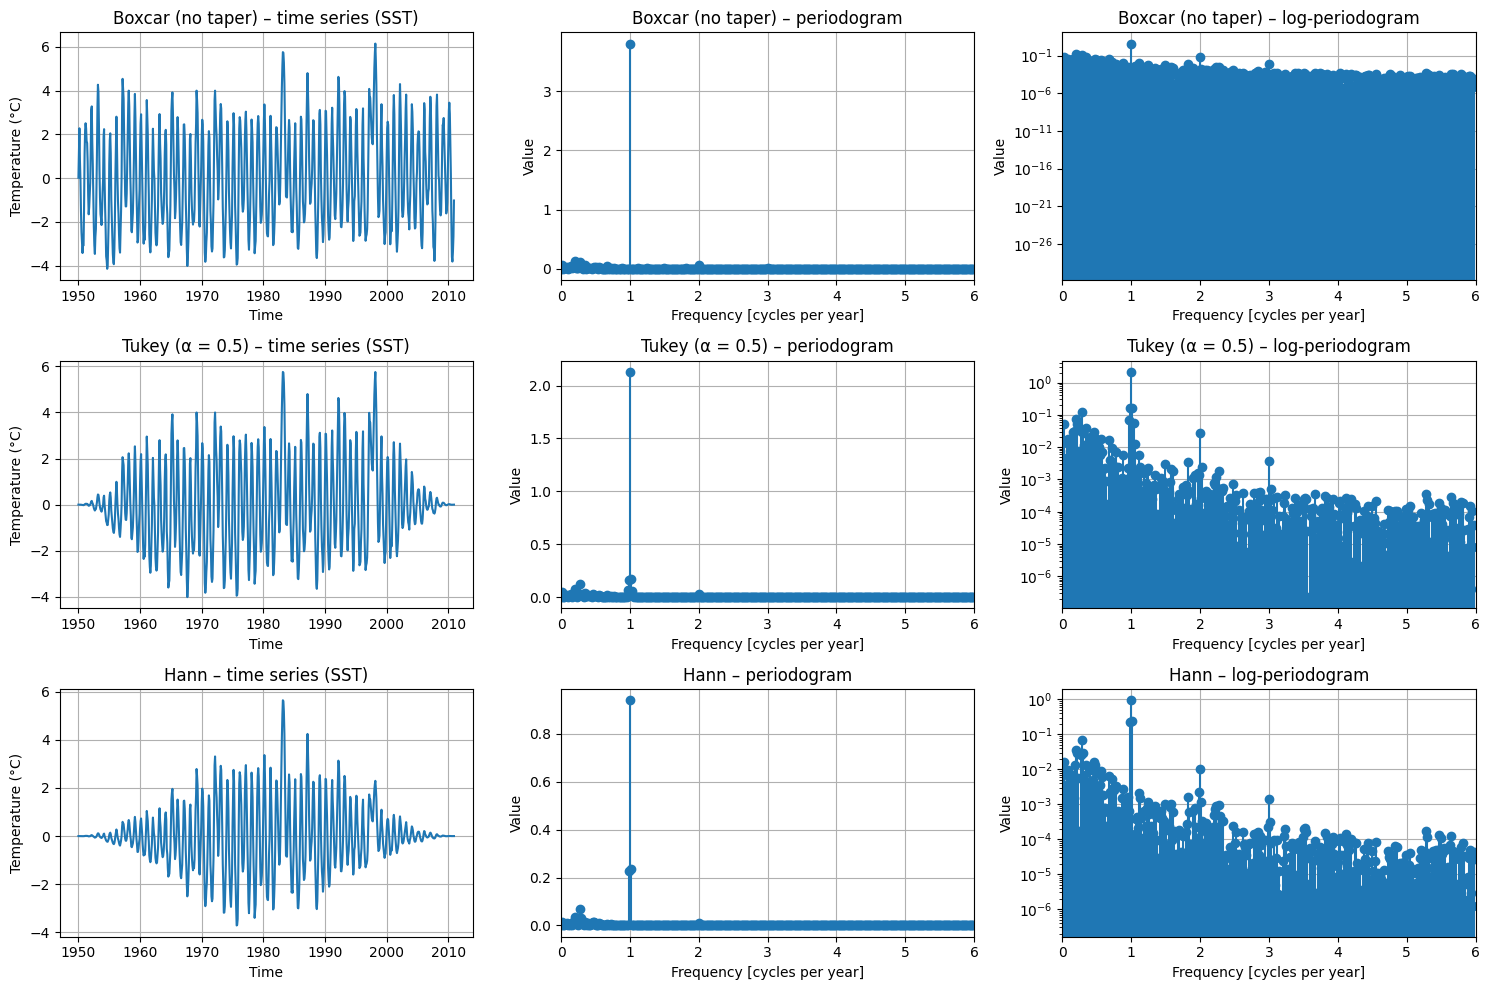

In [ ]:
from data.ex_data import get_sea_surface_temp

sst_df = get_sea_surface_temp().set_index("DATE").sort_index()
sst = sst_df["value"].asfreq("MS")
sst = sst - sst.mean()

windows = [
    ("Boxcar (no taper)", np.ones(len(sst))),
    ("Tukey (α = 0.5)", signal.windows.tukey(len(sst), alpha=0.5)),
    ("Hann", signal.windows.hann(len(sst))),
]

fig, axs = get_figure(nrows=len(windows), ncols=3, figsize=(15, 10))

for i, (name, w) in enumerate(windows):
    tapered = sst * w

    # Time plot
    time_plot(
        x=sst.index,
        y=tapered,
        title=f"{name} – time series (SST)",
        xlabel="Time",
        ylabel="Temperature (°C)",
        ax=axs[3*i],
    )

    # Periodogram (linear scale)
    plot_fft(
        axs[3*i + 1],
        tapered,
        sample_spacing=1/12,            # 12 obs per year
        sample_spacing_name="year",
        periodogram=True,
    )
    axs[3*i + 1].set_title(f"{name} – periodogram")
    axs[3*i + 1].set_xlim(0, 6)        # cycles per year

    # Periodogram (log scale)
    plot_fft(
        axs[3*i + 2],
        tapered,
        sample_spacing=1/12,
        sample_spacing_name="year",
        periodogram=True,
        log_scale=True,
    )
    axs[3*i + 2].set_title(f"{name} – log-periodogram")
    axs[3*i + 2].set_xlim(0, 6)

fig.tight_layout()


### Sea surface temperature – smoothed periodogram

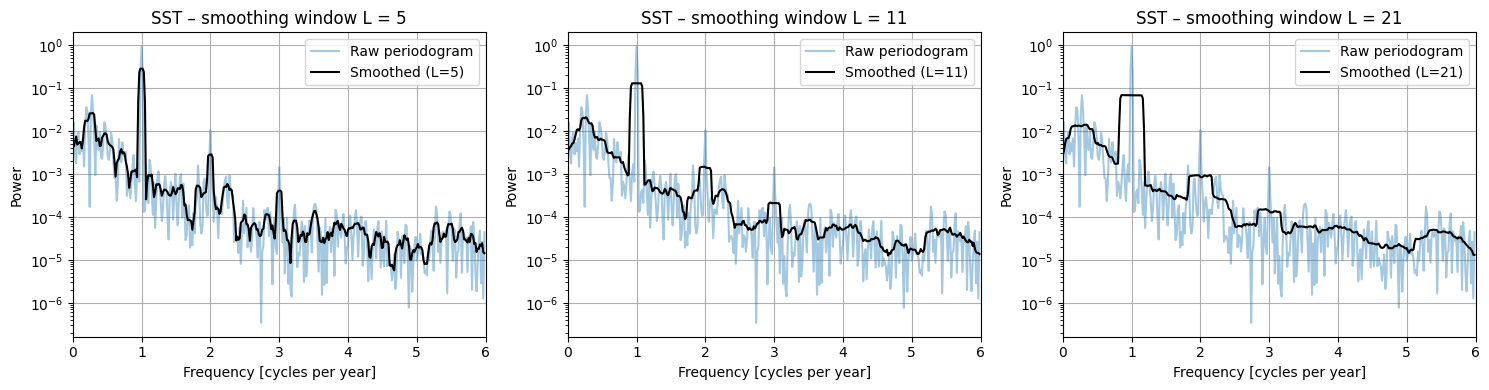

In [ ]:
# Hann-taper 
w_hann = signal.windows.hann(len(sst))
sst_tapered = sst * w_hann

def sst_smoothed_periodogram(series, window_size):
    fig_dummy, [ax_dummy] = get_figure()  
    xf, _, P = plot_fft(
        ax_dummy,
        series,
        sample_spacing=1/12,
        sample_spacing_name="year",
        periodogram=True,
        return_fft=True,
    )
    plt.close(fig_dummy)  

    _, _, P_smooth = moving_average_smoothing(P, window_size=window_size, mode="same")
    return xf, P, P_smooth

window_sizes = [5, 11, 21]  
fig, axs = get_figure(nrows=1, ncols=3, figsize=(15, 4))

for ax, wsize in zip(axs, window_sizes):
    xf, P_raw, P_s = sst_smoothed_periodogram(sst_tapered, window_size=wsize)
    ax.plot(xf, P_raw, alpha=0.4, label="Raw periodogram")
    ax.plot(xf, P_s, color="black", label=f"Smoothed (L={wsize})")
    ax.set_xlim(0, 6)
    ax.set_yscale("log")
    ax.set_title(f"SST – smoothing window L = {wsize}")
    ax.set_xlabel("Frequency [cycles per year]")
    ax.set_ylabel("Power")
    ax.legend()

fig.tight_layout()


### Sea surface temperature – effect of linear filters

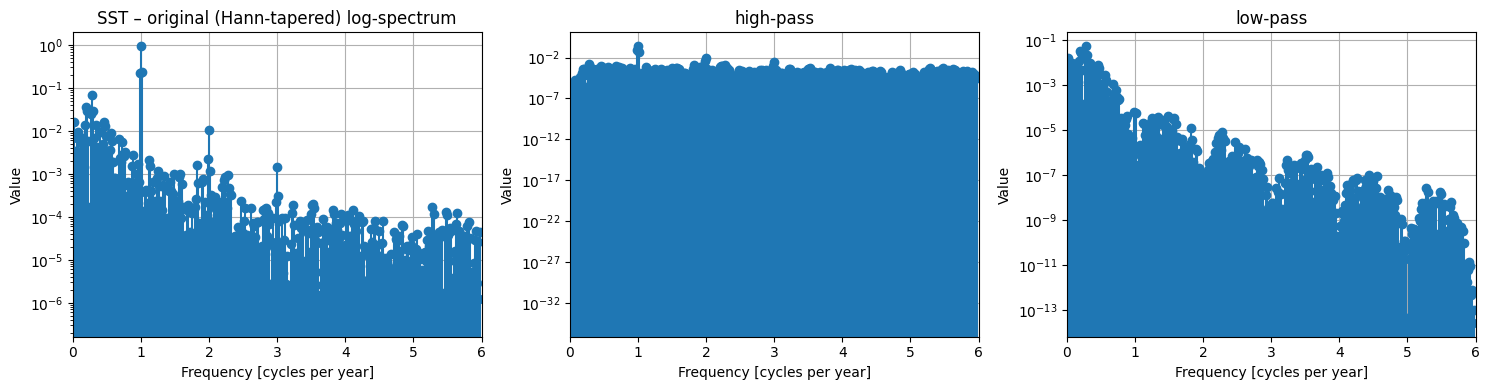

In [ ]:
import pandas as pd
orig = sst_tapered

# high-pass
diff_series = orig.diff().dropna()

# modified kernel with m = 6
# symmetric weights of length 2m+1 = 13
a = np.zeros(13)
a[0] = a[-1] = 1/24         
a[1:-1] = 1/12               
# keep same length
daniell_values = np.convolve(orig.values, a, mode="same")
daniell_series = pd.Series(daniell_values, index=orig.index)

fig, axs = get_figure(nrows=1, ncols=3, figsize=(15, 4))

plot_fft(
    axs[0],
    orig,
    sample_spacing=1/12,
    sample_spacing_name="year",
    periodogram=True,
    log_scale=True,
)
axs[0].set_title("SST – original (Hann-tapered) log-spectrum")
axs[0].set_xlim(0, 6)

# high-pass
plot_fft(
    axs[1],
    diff_series,
    sample_spacing=1/12,
    sample_spacing_name="year",
    periodogram=True,
    log_scale=True,
)
axs[1].set_title("high-pass")
axs[1].set_xlim(0, 6)

# low-pass
plot_fft(
    axs[2],
    daniell_series,
    sample_spacing=1/12,
    sample_spacing_name="year",
    periodogram=True,
    log_scale=True,
)
axs[2].set_title("low-pass")
axs[2].set_xlim(0, 6)

fig.tight_layout()
